# **Project: Amazon Product Recommendation System**




Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

As a Data Science Manager at Amazon, I have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. I have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [60]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


## **Importing the necessary libraries and overview of the dataset**

In [61]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# Display markdown formatted output like bold, italic bold etc.
from IPython.display import Markdown
def bold(string):
    return display(Markdown(f"**{string}**"))

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [62]:
# Importing the dataset
amazon_review = pd.read_csv('ratings_Electronics.csv')
amazon_review.columns =['user_id', 'prod_id', 'rating', 'timestamp']
#Dropping the "timestamp" column
data = amazon_review.drop("timestamp", axis = 1)


In [63]:
data.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [64]:
df=data.copy(deep = True)

Let's check the **info** of the data.

In [65]:
# This method is used to get the info of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


- There are **7,824,481 rows** and **3 columns** in the data.

**As this dataset is very large and has 7,824,481 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [66]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [67]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [68]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [69]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [70]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [71]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

**Observations :** 
There are **65,290 rows** and **3 columns** in the data.

### **Data types**

In [72]:
# Check Data types and provide observations
display(df_final.dtypes) 

user_id     object
prod_id     object
rating     float64
dtype: object

**Observations:** 
The variables **user_id** and **prod_id** are object data type and **rating** is a numeric data type.

### **Checking for missing values**

In [73]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations :** 
This dataset has no missing values.

### **Summary Statistics**

In [74]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Observations :** 
- The variable rating is slightly **left skewed**, with  some outliers on the left end.
- Ratings are ranging from 1 to 5.
- 1/4 of the products received a rating of 4 or less.

### **Checking the rating distribution**

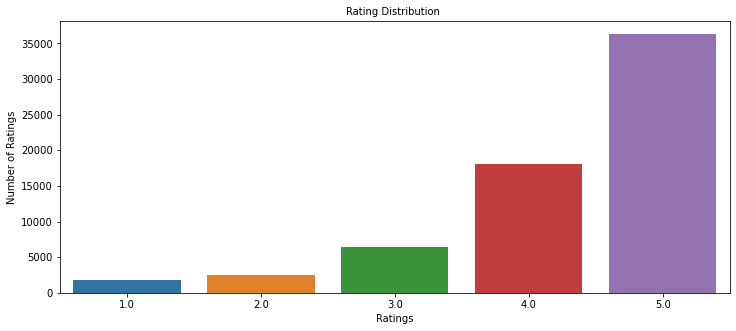

In [75]:
# Create the bar plot and provide observations
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "rating", data = df_final)

plt.tick_params(labelsize = 10)

plt.title("Rating Distribution ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

**Observations:**

* The data seems to be **highly skewed** towards Rating **'5'**. Rating **'4'** is the second-highest in the count and nearly the same as the number of **'1', '2' and '3'** rating counts put together. 

* One observes that very few people are giving ratings **between 1 to 3**. This suggests that customers tend to **not give a rating** for electronic products **not meeting their expectations.**

### **Checking the number of unique users and items in the dataset**

In [76]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows
bold("Number of total rows:")
display(df_final.shape[0])

#Number of unique users
bold("Number of unique users:")
display(df_final['user_id'].nunique())

# Number of unique products
bold("Number of unique products:")
display(df_final['prod_id'].nunique())

**Number of total rows:**

65290

**Number of unique users:**

1540

**Number of unique products:**

5689

**Observations:**
- There are **65,290 rows** in the dataset.
- There are **1,540 unique users** in the dataset.
- There are **5,689 unique products** in the dataset.
- So, there are **1,540 * 5,689 = ~8761060 possible ratings** in the dataset. But **we only have 65,290 ratings.** Therefore, not every customer has rated all products in the dataset. And, thus we can build a recommendation system to recommend a product to users who have not bought it.

### **Users with the most number of ratings**

In [77]:
# Top 10 users based on the number of ratings
most_rated= df_final['user_id'].value_counts().head(10)
most_rated

ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64

###### **Observations:**
- The top 10 users based on the number of ratings had at least 179 ratings each, with the user with user_id **ADLVFFE4VBT8** having the most number of ratings, i.e., **295** ratings. So for that user for example, there are still  **5689-295 =  5,394** more products in our dataset that this user did not rate . For those **5,394** remaining products, we can build a recommendation system to predict which products are most likely to be reviewed by this user. 

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

We will take the **average** of all the ratings provided to each product and then rank them based on their average rating.

In [78]:
# Calculate the average rating for each product 
average_rating = df_final.groupby('prod_id').mean()['rating']
# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']
# Create a dataframe with calculated average and count of ratings
dataframe_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating = dataframe_rating.sort_values(by = 'avg_rating', ascending = False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


Now, let's create a function to find the **top n products** for a recommendation based on the average ratings of the product. We  also add a **threshold for a minimum number of interactions** for a product to be considered for recommendation. This function can be used with different n's and minimum interactions** to get products to recommend.

In [79]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_product(final_rating, n, min_interaction):    
    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]
    # Sorting values with respect to average rating 
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [80]:
list(top_n_product(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [81]:
list(top_n_product(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [82]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [83]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [84]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Loading the rating dataset
df = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(df, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [85]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations:**

- The **RMSE** which **shows far the overall predicted ratings** are from the **actual ratings** is 1.0012.
- Intuition of Recall - We are getting a **recall of almost 0.858**, which means out of **all the relevant products, 85.8% are recommended**. 
- Intuition of Precision - We are getting a **precision of almost 0.885**, which means **out of all the recommended products 85.5% are relevant**.
- We obtained a **F_1 score** for the **baseline model** to be about **0.856**. This indicates that the model **found mostly recommended products to be relevant** and the model **recommended relevant products** to the user.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [86]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Observation:**

This **user-user-similarity-based baseline model** is **under-estimating the ratings** since **the actual rating for this user-item pair is 5 and the predicted rating is 3.40.** 

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [87]:
# Find unique user_id where prod_id is not equal to "1400501466"
LIST = df_final[df_final['prod_id']!= 1400501466]['user_id'].unique()
LIST

array(['A3LDPF5FMB782Z', 'A1A5KUIIIHFF4U', 'A2XIOXRRYX0KZY', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

In [88]:
if 'A34BZM6S9L7QI4' in LIST.tolist():
    print (" User 'A34BZM6S9L7QI4' is found in the list"),
else:
    print (" User 'A34BZM6S9L7QI4' is not found in the list") 

 User 'A34BZM6S9L7QI4' is found in the list


**Observation:**

It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [89]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

  **The estimated rating for this user-item pair is 4.29** based on this similarity based baseline model. However the model can't made predictions for this user as it does not detect enough neighbors.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [90]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(df)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9714913272429824
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


**Observation:**
    **The best RMSE is about 0.97.**

Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [91]:
# Using the optimal similarity measure for user-user-based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**Observation:**

 After tuning hyperparameters, the **F_1 score of the model has increased a little bit as compared to the baseline model,** from 0.856 to 0.87**.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [92]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

**The optimized user-user-similarity-based model** is also **under-estimating the ratings** since **the actual rating for this user-item pair is 5 and the predicted rating is 4.29.** But the estimate is significantly closer to the actual rating.

In [93]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

  **The estimated rating for this user-item pair is also 4.29** based on this optimized similarity based  model. Note that this is identical to the estimated rating yielded by the baseline model for this user-item pair. Also, the model still can't make predictions for this user as it does not detect enough neighbors.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [94]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [95]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [96]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

In [97]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [98]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Observations:**
- Again, **RMSE** is calculated to check **how far the overall predicted ratings** are from the **actual ratings**.
- Intuition of Recall - We are getting a **recall of 0.845**, which means out of **all the relevant products, 84.5% are recommended**. 
- Intuition of Precision - We are getting a **precision of almost 0.838**, which means **out of all the recommended products 83.8% are relevant**.
- We obtained a **F_1 score** for the **baseline model** to be about **0.845**. This also indicates that the model **found mostly recommended products to be relevant** and the model **recommended relevant products** to the user.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [99]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Observation:**

**item-item-similarity-based model** is also **under-estimating the ratings** since **the actual rating for this user-item pair is 5 and the predicted rating is 4.27.** But the estimate is significantly closer to the actual rating.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [100]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observation:**

  **The predicted rating for this user-item pair is again 4.29** based on this item-item similarity based  model. Note that this is identical to the predicted rating yielded by the user-user similarity based  model for this user-item pair. Also, the model  can't make predictions for this user as it does not detect enough neighbors.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [101]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(df)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9755272361098543
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


**Observation:**

 - **The best RMSE is also about 0.97.**
 - The **optimal values** for the hyperparameters are **{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}**.

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [102]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:** After tuning hyperparameters, one observes that the  **F_1 score of the tuned model is also slightly greater than the F_1 score of the baseline model**. In addition,  the RMSE value after tuning the hyperparameters has decreased. So the tuned model is doing better than the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [103]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [104]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

- Here the optimized model is predicting a rating from **userId="A3LDPF5FMB782Z"**  of  **4.71** for the product whose actual rating is 5. 
- **The predicted rating from this user on the product with **productId "1400501466"** is again **4.29** based on this optimized item-item similarity based  model. Note that this is identical to the predicted rating yielded by the optimized user-user similarity based  model for this user-item pair.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [105]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [106]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [107]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


**Observation:**
We find that the top 5 recommendations for user_id A1A5KUIIIHFF4U with this similarity-based recommendation engine  have the same predicted_ratings.    
    

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [108]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observation:** 

The baseline model with the SVD matrix factorization algorithm performs well,  with a good F-1 score of **86.6%**.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [109]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Observation:**

This model is also **under-estimating the ratings** since **the actual rating for this user-item pair is 5 and the predicted rating is 4.08.** But the estimate is close to the actual rating.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [110]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

**Observations:**

The **estimated rating** for this **user-item pair** is ~4.40 based on this **matrix factorization based baseline model**.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [111]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(df)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8973183807454594
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


**Observation:**

 - **The best RMSE is also about 0.90.**
 - The **optimal values** for the hyperparameters are **{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}**.

Now, we will build **the final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [112]:
# Building the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.4, random_state = 1)

# Training the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8822
Precision:  0.854
Recall:  0.884
F_1 score:  0.869


**Observations:** After tuning hyperparameters, one observes that the  **F_1 score of the tuned model is pretty much the same as the F_1 score of the baseline model**. But,  the RMSE value after tuning the hyperparameters has just slightly decreased. So the tuned model is really not doing better than the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [113]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0394144191097014, details={'was_impossible': False})

**Observation:**

This model is also **under-estimating the ratings** since **the actual rating for this user-item pair is 5 and the predicted rating is 4.13.** But the estimate is close to the actual rating.

In [114]:
# Using svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.17   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.172649353607237, details={'was_impossible': False})

**Observations:**

The **predicted rating** for this **user-item pair** is ~4.22 based on this **optimized model with the SVD matrix factorization algorithm.** 

In [115]:
# Getting top 5 recommendations for user_id A3LDPF5FMB782Z using "svd_optimized" algorithm
svd_recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, svd_optimized)

In [116]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(svd_recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00006HSYC,4.775916
1,B0010Y414Q,4.765719
2,B00AR95ESC,4.748074
3,B00IVPU6AA,4.734200
4,B002EEP3MK,4.733098


### **Conclusion and Recommendations**

In this case study, we built recommendation systems using four different algorithms  to recommend products to customers based on their previous ratings for other products. These algorithms are:
- Rank-based using averages
- User-user-similarity-based collaborative filtering
- Item-item-similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

- We used the **surprise** library and applied **grid search cross-validation to find  the optimal hyperparameters for the data in order to determine the best working model.** 
- In each model built, we made predictions for ratings on some products and users. The user with userId="A34BZM6S9L7QI4" who has not interacted with prod_id ="1400501466" could not get their ratings of that product predicted by both the optimized User-user-similarity-based collaborative filtering and the optimized item-item-similarity-based collaborative filtering. However, one could predict that user's rating using the model-based (matrix factorization) collaborative filtering.

- We used precision@k and recall@k as metrics to evaluate performance on all these models and found all to be good models using their **F_1 scores** from the two metrics.
- Among all the models, the tuned model-based (matrix factorization) collaborative filtering seems to perform slightly better than the rest of them in terms of both the F1-Score (~ 0.87) and the RMSE (~ 0.822)

- We found that tuning the model-based (matrix factorization) collaborative filtering did not improve the model, and both could help making recommendations to the given users. But tuning the similarity  models slightly improved the models, but could not detect enough neighbors with sufficient overlap in their preferences to make reliable recommendations.
- For the provided users for which we could not find enough neighbors with the user-user recommendation system is unable to make  a prediction ratings for a reliable recommendation, we could change parameters to find these neighbors.